[View in Colaboratory](https://colab.research.google.com/github/AshwiniBaipadithayaMadhusudan/San-Francisco-Crime-Classification/blob/master/SFcrime.ipynb)

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!wget https://launchpad.net/~alessandro-strada/+archive/ubuntu/google-drive-ocamlfuse-beta/+build/15331130/+files/google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!dpkg -i google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!apt-get install -f
!apt-get -y install -qq fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive


In [0]:
!pip install fastai==0.7.0 
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics



In [0]:
PATH="/content/drive/fastaiSFCRIME/SFCRIMEDATA/" 

In [8]:
!ls {PATH}

sampleSubmission.csv  test.csv	train.csv


In [0]:
df_train=pd.read_csv(f'{PATH}train.csv')
df_raw_train=df_train.copy()

In [0]:
df_test=pd.read_csv(f'{PATH}test.csv')
df_raw_test=df_test.copy()

In [0]:
df_trn=df_train#.take(np.random.permutation(len(df_train))[:50000])
y_trn=df_trn['Category']

In [0]:
df_trn=df_trn.drop(['Category','Descript','Resolution'],axis=1)
#df_test=df_test.drop(['Category','Descript','Resolution'],axis=1)

In [0]:
df_trn['Dates']=pd.to_datetime(df_trn['Dates'])
df_trn['DatesHour']=df_trn['Dates'].apply (lambda x: ((x.hour *60) + x.minute))

df_test['Dates']=pd.to_datetime(df_test['Dates'])
df_test['DatesHour']=df_test['Dates'].apply (lambda x: ((x.hour *60) + x.minute))
#df_trn['DatesHour'].head(30)

In [0]:
df_trn['Earlymorning']= df_trn['DatesHour'].apply (lambda x: (3*60 < x <= 7*60))
df_trn['Latenight']   = df_trn['DatesHour'].apply (lambda x: ( x <= 3*60))
df_trn['Morning']     = df_trn['DatesHour'].apply (lambda x: (7*60 < x <= 11*60))
df_trn['Noon']        = df_trn['DatesHour'].apply (lambda x: (11*60 < x <= 16*60))
df_trn['Eve']         = df_trn['DatesHour'].apply (lambda x: (16*60 < x <= 20*60))
df_trn['Night']       = df_trn['DatesHour'].apply (lambda x: (x > 20*60))

df_test['Earlymorning']= df_test['DatesHour'].apply (lambda x: (3*60 < x <= 7*60))
df_test['Latenight']   = df_test['DatesHour'].apply (lambda x: ( x <= 3*60))
df_test['Morning']     = df_test['DatesHour'].apply (lambda x: (7*60 < x <= 11*60))
df_test['Noon']        = df_test['DatesHour'].apply (lambda x: (11*60 < x <= 16*60))
df_test['Eve']         = df_test['DatesHour'].apply (lambda x: (16*60 < x <= 20*60))
df_test['Night']       = df_test['DatesHour'].apply (lambda x: (x > 20*60))

In [94]:
df_trn.transpose().head(30)

,0,1,2,3,4,5,6,7,8,9,...,878039,878040,878041,878042,878043,878044,878045,878046,878047,878048
Dates,2015-05-13 23:53:00,2015-05-13 23:53:00,2015-05-13 23:33:00,2015-05-13 23:30:00,2015-05-13 23:30:00,2015-05-13 23:30:00,2015-05-13 23:30:00,2015-05-13 23:30:00,2015-05-13 23:00:00,2015-05-13 23:00:00,...,2003-01-06 00:40:00,2003-01-06 00:33:00,2003-01-06 00:31:00,2003-01-06 00:20:00,2003-01-06 00:20:00,2003-01-06 00:15:00,2003-01-06 00:01:00,2003-01-06 00:01:00,2003-01-06 00:01:00,2003-01-06 00:01:00
DayOfWeek,Wednesday,Wednesday,Wednesday,Wednesday,Wednesday,Wednesday,Wednesday,Wednesday,Wednesday,Wednesday,...,Monday,Monday,Monday,Monday,Monday,Monday,Monday,Monday,Monday,Monday
PdDistrict,NORTHERN,NORTHERN,NORTHERN,NORTHERN,PARK,INGLESIDE,INGLESIDE,BAYVIEW,RICHMOND,CENTRAL,...,NORTHERN,MISSION,RICHMOND,BAYVIEW,BAYVIEW,TARAVAL,INGLESIDE,SOUTHERN,SOUTHERN,BAYVIEW
Address,OAK ST / LAGUNA ST,OAK ST / LAGUNA ST,VANNESS AV / GREENWICH ST,1500 Block of LOMBARD ST,100 Block of BRODERICK ST,0 Block of TEDDY AV,AVALON AV / PERU AV,KIRKWOOD AV / DONAHUE ST,600 Block of 47TH AV,JEFFERSON ST / LEAVENWORTH ST,...,POLK ST / CALIFORNIA ST,2800 Block of FOLSOM ST,CLEMENT ST / 14TH AV,1500 Block of SHAFTER AV,1500 Block of SHAFTER AV,FARALLONES ST / CAPITOL AV,600 Block of EDNA ST,5TH ST / FOLSOM ST,TOWNSEND ST / 2ND ST,1800 Block of NEWCOMB AV
X,-122.426,-122.426,-122.424,-122.427,-122.439,-122.403,-122.423,-122.371,-122.508,-122.419,...,-122.421,-122.414,-122.473,-122.39,-122.39,-122.459,-122.447,-122.403,-122.391,-122.395
Y,37.7746,37.7746,37.8004,37.8009,37.7715,37.7134,37.7251,37.7276,37.7766,37.8078,...,37.7906,37.7517,37.7826,37.7306,37.7306,37.7141,37.7319,37.7803,37.7806,37.7382
DatesHour,1433,1433,1413,1410,1410,1410,1410,1410,1380,1380,...,40,33,31,20,20,15,1,1,1,1
Earlymorning,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Latenight,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
Morning,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [0]:
df_test.drop('Id',axis=1,inplace=True)

In [0]:
#train_cats(df_trn)
#add_datepart(df_trn,'Dates')

apply_cats(df_test,df_trn)
add_datepart(df_test,'Dates')

In [0]:
df_trn.drop(['DayOfWeek','DatesHour','Address','DatesElapsed'],axis=1,inplace=True)
df_test.drop(['DayOfWeek','DatesHour','Address','DatesElapsed'],axis=1,inplace=True)

In [0]:
df_trn=pd.get_dummies(df_trn,columns=['PdDistrict','DatesMonth','DatesDayofweek'],drop_first=True)
df_test=pd.get_dummies(df_test,columns=['PdDistrict','DatesMonth','DatesDayofweek'],drop_first=True)

In [98]:
df_trn.transpose().head(100)

,0,1,2,3,4,5,6,7,8,9,...,878039,878040,878041,878042,878043,878044,878045,878046,878047,878048
X,-122.426,-122.426,-122.424,-122.427,-122.439,-122.403,-122.423,-122.371,-122.508,-122.419,...,-122.421,-122.414,-122.473,-122.39,-122.39,-122.459,-122.447,-122.403,-122.391,-122.395
Y,37.7746,37.7746,37.8004,37.8009,37.7715,37.7134,37.7251,37.7276,37.7766,37.8078,...,37.7906,37.7517,37.7826,37.7306,37.7306,37.7141,37.7319,37.7803,37.7806,37.7382
Earlymorning,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Latenight,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
Morning,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Noon,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Eve,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Night,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
DatesYear,2015,2015,2015,2015,2015,2015,2015,2015,2015,2015,...,2003,2003,2003,2003,2003,2003,2003,2003,2003,2003
DatesWeek,20,20,20,20,20,20,20,20,20,20,...,2,2,2,2,2,2,2,2,2,2


In [0]:
le=LabelEncoder()
y_trnenc=le.fit_transform(y_trn)

In [100]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 5000  # same as Kaggle's test set size
n_trn = len(df_trn)-n_valid
#raw_train, raw_valid = split_vals(df_trn, n_trn)
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trnenc, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((873049, 44), (873049,), (5000, 44))

In [0]:
def print_score(m):
    res = [metrics.log_loss(y_train, m.predict_proba(X_train),labels=list(set(y_train))), metrics.log_loss(y_valid, m.predict_proba(X_valid),labels=list(set(y_train))),
                m.score(X_train, y_train)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)


In [102]:
m = RandomForestClassifier(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.542290082769994, 14.089453441397392, 0.8283040241727555]


In [103]:
m = RandomForestClassifier(n_estimators=70,n_jobs=-1,max_features='log2',min_samples_leaf=8)
m.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [104]:
print_score(m)

[1.8616893206380913, 2.5465102584979817, 0.40160403367966746]


In [105]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
1,Y,0.195732
0,X,0.184733
8,DatesYear,0.096932
11,DatesDayofyear,0.096652
10,DatesDay,0.089722
9,DatesWeek,0.055192
26,PdDistrict_TENDERLOIN,0.022534
41,DatesDayofweek_4,0.013260
40,DatesDayofweek_3,0.013073
38,DatesDayofweek_1,0.012830


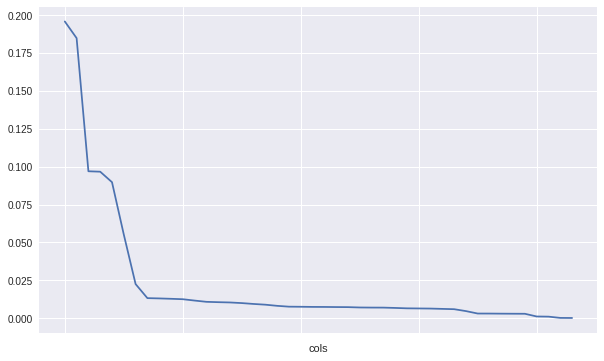

In [106]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [0]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

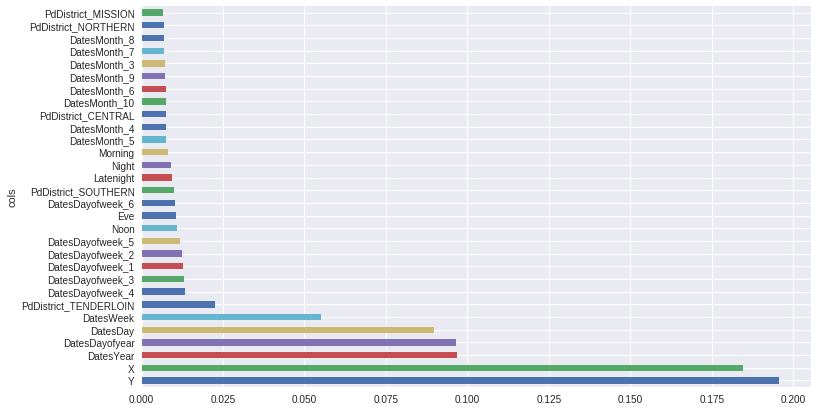

In [108]:
plot_fi(fi[:30]);

In [109]:
to_keep = fi[fi.imp>0.017].cols; len(to_keep)

7

In [0]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)
y_train, y_valid = split_vals(y_trnenc,n_trn)

In [111]:
m = RandomForestClassifier(n_estimators=150, min_samples_leaf=20, max_features='log2',
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[2.018634011877098, 2.550380577182677, 0.3474134899644808, 0.2845498935340399]


In [0]:
from scipy.cluster import hierarchy as hc

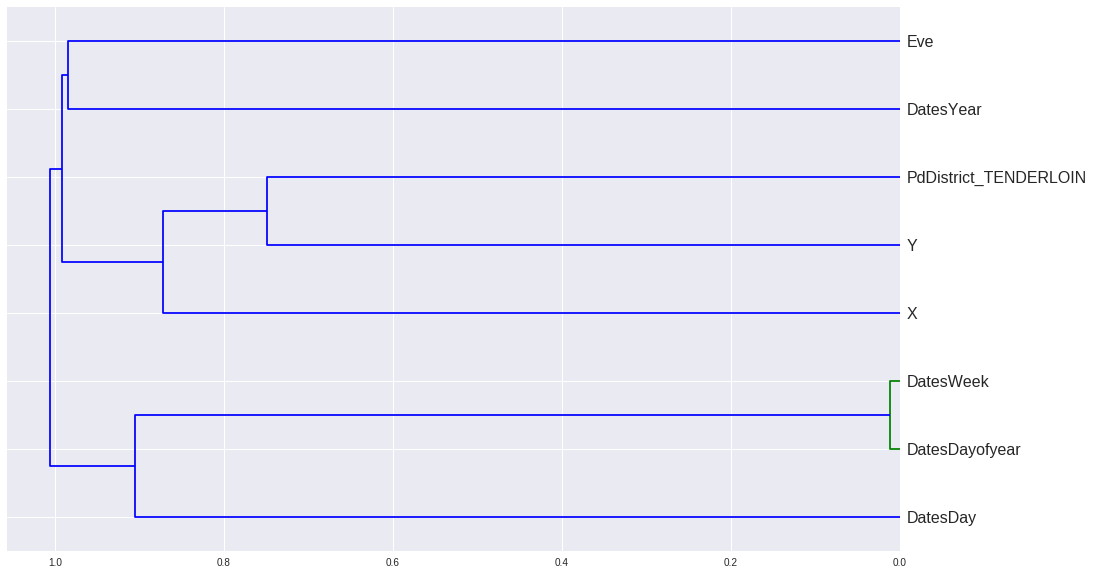

In [80]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [0]:
#df_trn_save=df_trn
df_trn=df_trn_save

In [0]:
df_trn.drop('DatesWeek',axis=1,inplace=True)
df_test.drop('DatesWeek',axis=1,inplace=True)

In [0]:
#df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trnenc,n_trn)

In [133]:
m = RandomForestClassifier(n_estimators=150, min_samples_leaf=20, max_features='log2',
                          n_jobs=-1, oob_score=True)
m.fit(df_trn, y_trnenc)
#print_score(m)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [0]:
rfpred=m.predict_proba(df_test)

In [0]:
df_sub=pd.DataFrame(rfpred,index=df_test.index,columns=np.unique(y_trn))
df_sub.index.name='Id'
#df_sub.idxmax(axis=1)

In [138]:
df_sub.head()

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Id,,,,,,,,,,,,,,,,,,,,,
0,0.005460,0.110029,0.000006,0.000186,0.032583,0.000649,0.005630,0.039438,0.001965,0.000615,...,0.000019,0.005841,0.000979,0.037094,0.000000e+00,0.002944,0.059598,0.097513,0.036860,0.025847
1,0.008818,0.121205,0.000091,0.000871,0.023990,0.001508,0.006699,0.064635,0.003406,0.000054,...,0.000091,0.007336,0.000793,0.044166,8.674908e-07,0.003834,0.047685,0.083927,0.053555,0.032820
2,0.004553,0.079147,0.000000,0.000011,0.069100,0.001042,0.005055,0.015542,0.005690,0.000110,...,0.000000,0.010539,0.000028,0.021894,0.000000e+00,0.008452,0.062928,0.066736,0.023288,0.003569
3,0.002221,0.097273,0.000008,0.000050,0.018427,0.000407,0.005750,0.029383,0.005533,0.000251,...,0.000036,0.005140,0.000769,0.041443,0.000000e+00,0.001798,0.082806,0.172292,0.029899,0.010058
4,0.002221,0.097273,0.000008,0.000050,0.018427,0.000407,0.005750,0.029383,0.005533,0.000251,...,0.000036,0.005140,0.000769,0.041443,0.000000e+00,0.001798,0.082806,0.172292,0.029899,0.010058


In [0]:
import os
os.chdir("/content/drive/fastaiSFCRIME/SFCRIMEDATA/")
df_sub.to_csv('SFCRIMERF.csv')

In [148]:
!ls

adc.json  google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb  SFCRIMERF.csv
drive	  sample_data
